In [1]:
import jax
import jax.numpy as jnp
from jax import random

import numpy as np

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, log_likelihood

import matplotlib.pyplot as plt

from model import *

plt.rcParams['font.size'] = 14
# plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=False
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 1.0
plt.rcParams['axes.axisbelow'] = True

/Users/murakami/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


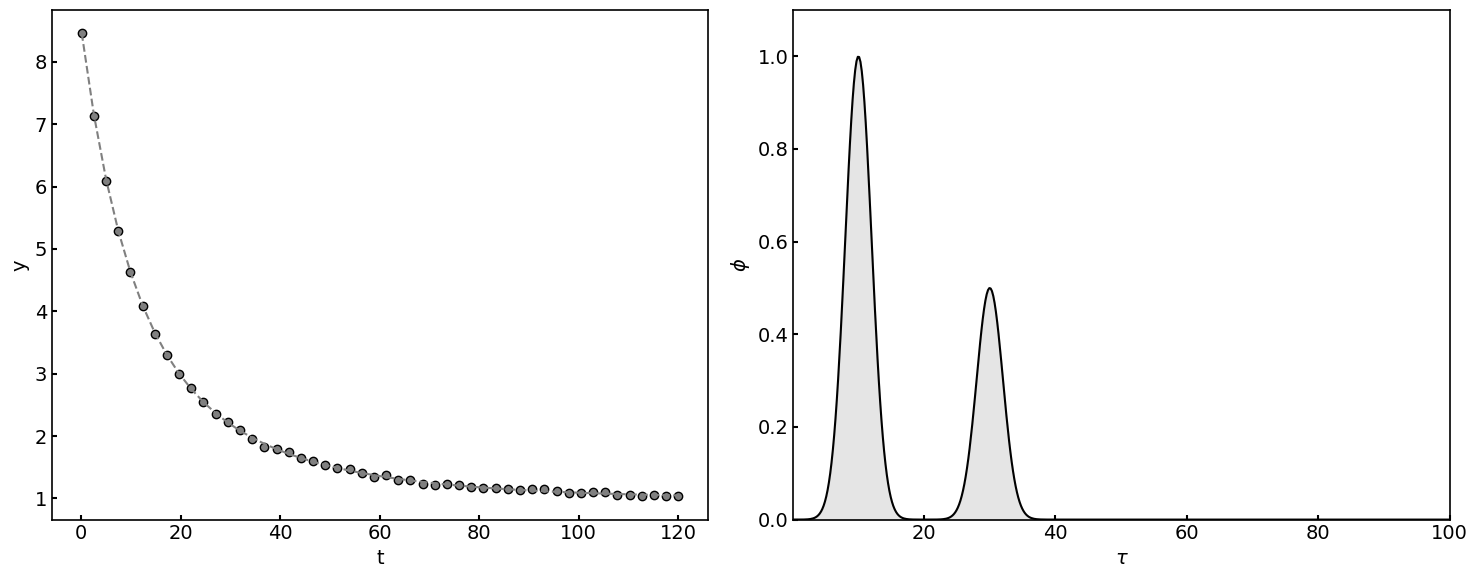

In [2]:

# 離散化されたτ空間（例: 対数スケールで10^-1 ～ 10^2）
N = 500
# tau = jnp.linspace(0.1, 100.0, N)  # τ: (N,)
tau = jnp.linspace(0.1, 100.0, N)  # τ: (N,)

# 入力時間軸
M = 50
t = jnp.linspace(0.1, 120.0, M)  # t: (M,)

b=1
h_true=jnp.array([1.0, 0.5])
mu_true=jnp.array([10.0, 30.0])
sigma_true=jnp.array([2.0, 2.0])
phi_true = calc_phi_K(tau, h_true, mu_true, sigma_true)
y_true = calc_f_K(t, tau, b, h_true, mu_true, sigma_true)

key = random.PRNGKey(0)
sigma_y_true = 0.02
noise = sigma_y_true * random.normal(key, shape=y_true.shape)
y_obs = y_true + noise

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(t, y_true, ls='--', color='gray')
plt.scatter(t, y_obs, color='gray', edgecolor='k')
plt.xlabel(r't')
plt.ylabel(r'y')

plt.subplot(122)
plt.plot(tau, phi_true, c='k')
plt.fill_between(tau, phi_true, color='gray', alpha=0.2)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')
plt.xlim(tau.min(), tau.max())
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

In [3]:
num_samples = num_warmup = 2000
num_chains = 10
K = 2

kernel = NUTS(model, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
mcmc.run(random.PRNGKey(1), t=t, y_obs=y_obs, tau=tau, K=K)
mcmc.print_summary()

/var/folders/h6/361ss89923jd1mqx4n307p4w0000gn/T/ipykernel_58467/1535821803.py:6: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
sample: 100%|██████████| 4000/4000 [00:20<00:00, 193.28it/s, 1023 steps of size 2.08e-03. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.96      0.04      0.97      0.91      1.02    874.78      1.01
      h[0]      0.93      0.31      0.90      0.58      1.50    197.54      1.04
      h[1]      0.92      0.30      0.86      0.55      1.45    733.13      1.03
     mu[0]     27.45     15.72     30.16      9.08     46.23      6.95      1.94
     mu[1]     22.29     15.57     12.12      8.94     42.78      6.34      2.26
  sigma[0]      1.73      1.28      1.22      0.27      3.78      7.85      1.69
  sigma[1]      2.08      1.31      1.82      0.28      3.97      9.53      1.49
   sigma_y      0.02      0.00      0.02      0.02      0.02   4943.26      1.00

Number of divergences: 0


In [4]:
sorted_index = np.argsort( mcmc.get_samples()['mu'] )
samples = mcmc.get_samples()

In [11]:
sorted_samples = {}
keys = ['h', 'mu', 'sigma']
for key in keys:
    samples_k = []
    for i, j in enumerate(sorted_index):
        samples_k.append( samples[key][i, j] )
    samples_k = np.array( samples_k )
    sorted_samples[key] = samples_k

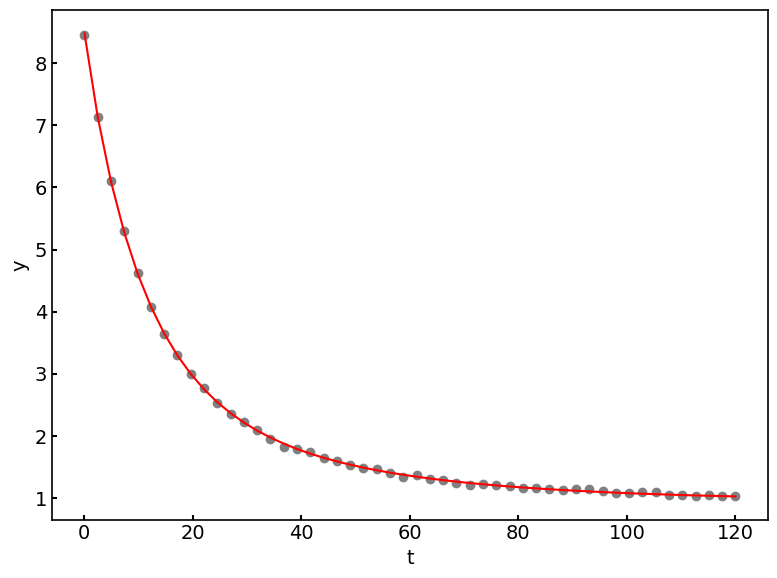

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(t, y_obs, c='gray')
plt.plot(t, mcmc.get_samples()['f'][-1, :], color='r')
plt.xlabel('t');plt.ylabel('y')
plt.tight_layout()
plt.show()

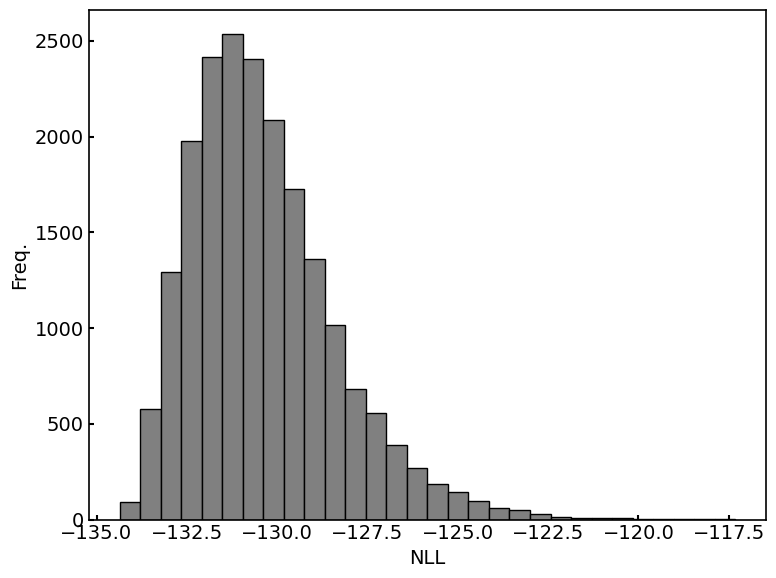

In [13]:
log_likelihood_dict = log_likelihood(
    model=model, posterior_samples=mcmc.get_samples(), 
    t=t, y_obs=y_obs, tau=tau, K=K)
nll = -1.0 * jnp.sum( log_likelihood_dict['obs'], axis=1)
plt.figure(figsize=(8, 6))
plt.hist(nll, bins=30, color='gray', edgecolor='k')
plt.xlabel('NLL'); plt.ylabel('Freq.')
plt.tight_layout()
plt.show()

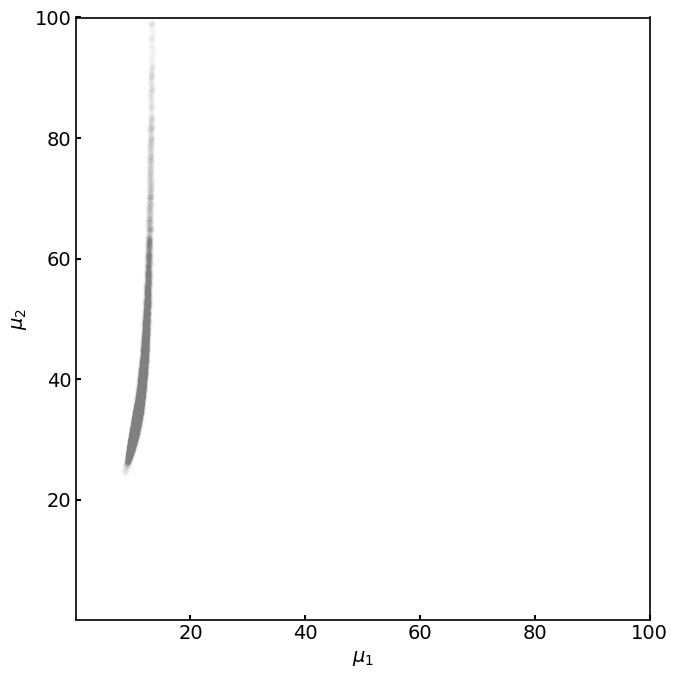

In [19]:
plt.figure(figsize=(7, 7))
plt.scatter(sorted_samples['mu'][:, 0], sorted_samples['mu'][:, 1], 
                    alpha=0.01, c='gray', s=10)
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.xlim(tau.min(), tau.max())
plt.ylim(tau.min(), tau.max())
plt.tight_layout()
plt.show()

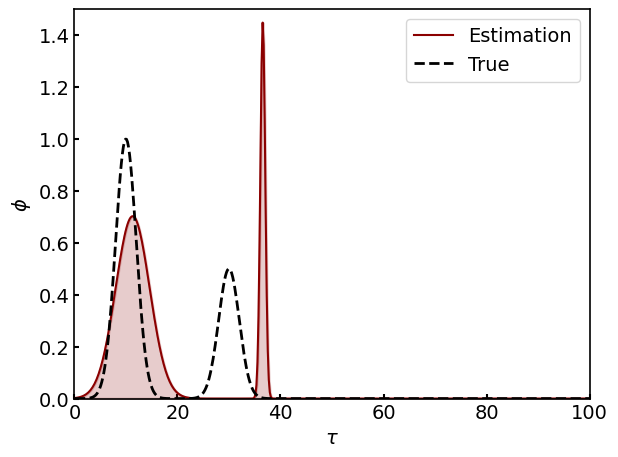

In [23]:
argmin_nll = np.argmin(nll)

tcd = np.zeros( len(tau) )
for k in range(K):
    est_sigma = np.mean( samples['sigma'][argmin_nll, k] )
    est_mean = np.mean( samples['mu'][argmin_nll, k] )
    est_height = np.mean( samples['h'][argmin_nll, k] )
    
    tcd += ( est_height * gaussian(tau, est_mean, est_sigma) )
    
plt.plot(tau, tcd, color='darkred', label='Estimation')
plt.fill_between(tau, tcd, color='darkred', alpha=0.2, lw=2)
    
plt.plot(tau, phi_true, c='k', ls='--', label='True', lw=2)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')

plt.legend()
plt.xlim(0, 100)
plt.ylim(0, 1.5)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')

plt.tight_layout()
plt.show()

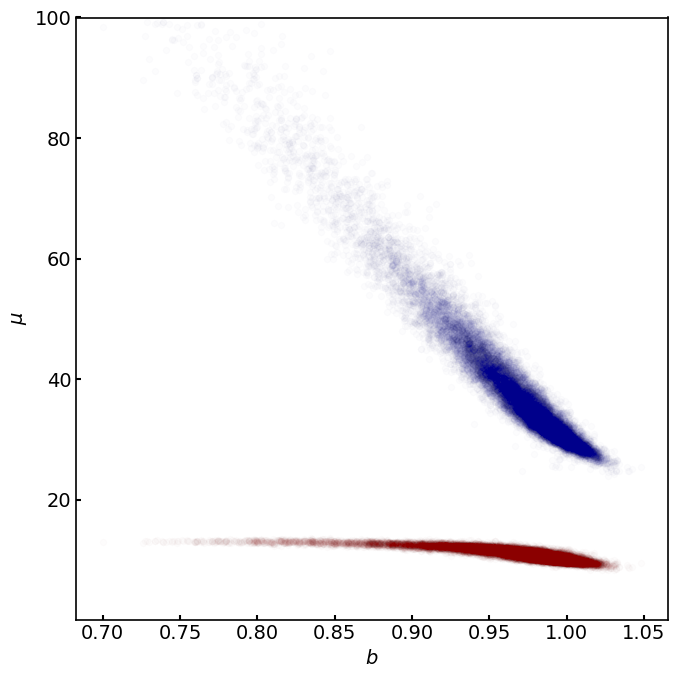

In [25]:
plt.figure(figsize=(7, 7))
plt.scatter(samples['b'], sorted_samples['mu'][:, 0], 
                    alpha=0.01, c='darkred', s=20)
plt.scatter(samples['b'], sorted_samples['mu'][:, 1], 
                    alpha=0.01, c='darkblue', s=20)
plt.xlabel(r'$b$')
plt.ylabel(r'$\mu$')
# plt.xlim(tau.min(), tau.max())
plt.ylim(tau.min(), tau.max())
plt.tight_layout()
plt.show()